# Read SUMMA output

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Offline Turbulence Package
import turbpy

# Customize
sns.set_style("whitegrid")
sns.set_context('talk')
%matplotlib inline

In [2]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/'

dirProj = dirPre + 'SnowHydrology/proj/ModTsfc/'
dirPrint = dirProj + 'Graphics'
dirData = dirProj + 'data'
dirSumma = dirProj + 'summa/ModTsfc_summa/output/'

## Functions to quickly evaluate all model output

In [3]:
os.chdir(dirData)
SWA = xr.open_dataset('SWA.ModTsfc.nc')
SNQ = xr.open_dataset('SNQ.ModTsfc.nc')
CDP = xr.open_dataset('CDP.ModTsfc.nc')

## Model output

### Define control lists etc

In [4]:
siteNames = ['SWA', 'CDP']
siteYears = {'SWA': np.arange(2006, 2012),
             'CDP': np.arange(2002, 2010)}

d1 = datetime(2002, 10, 1)
d2 = datetime(2010, 9, 30, 22, 0, 0)
CDP = CDP.loc[dict(time = slice(d1, d2))]
CDP_daily = CDP.resample(how='mean', freq='d', dim='time')

experiments = ['longwaveBias', 'shortwaveBias', 'specHumidBias',
               'airTempBias', 'windBias']

# ----------
# Experiment names - Met Uncertainty
metName = {'longwaveBias': 'LWRadAtm',
           'shortwaveBias': 'SWRadAtm',
           'specHumidBias': 'spechum',
           'airTempBias': 'airtemp',
           'windBias': 'windspd'}

# Experiment IDs and values
expNames = {'longwaveBias': ['lowLW_L','lowLW_S', 'highLW_S', 'highLW_L']}
expBias = {'longwaveBias': {'lowLW_L': -25, 'lowLW_S': -10, 'highLW_S': 10, 'highLW_L': 25}}

expNames['shortwaveBias'] = ['lowSW_L','lowSW_S', 'highSW_S', 'highSW_L']
expBias['shortwaveBias'] = {'lowSW_L': -80, 'lowSW_S': -30, 'highSW_S': 30, 'highSW_L': 80}

expNames['specHumidBias'] = ['lowQS_L','lowQS_S', 'highQS_S', 'highQS_L']
expBias['specHumidBias'] = {'lowQS_L': -25,  'lowQS_S': -10, 'highQS_S': 10, 'highQS_L': 25}

expNames['airTempBias'] = ['lowTair_L','lowTair_S', 'highTair_S', 'highTair_L']
expBias['airTempBias'] = {'lowTair_L': -3, 'lowTair_S': -1.5, 'highTair_S': 1.5, 'highTair_L': 3}

expNames['windBias'] = ['lowU_L','lowU_S', 'highU_S', 'highU_L']
expBias['windBias'] = {'lowU_L': -3, 'lowU_S': -1.5, 'highU_S': 1.5, 'highU_L': 3}

expNames['Obs'] = 'Obs'
expBias['Obs'] = 0.

# ----------
# Scalar variables to extract from output
scalar_data_vars = ['scalarRainPlusMelt', 'scalarSWE', 'scalarSnowSublimation', 
                    'scalarInfiltration', 'scalarSurfaceRunoff', 'scalarSurfaceTemp',
                    'scalarSenHeatTotal', 'scalarLatHeatTotal', 'scalarSnowDepth']

In [5]:
# Put all results in a single dictionary
resultsDict = {}
sN = 'CDP'
for exp in experiments:
    os.chdir(dirSumma + exp + '/' + sN)
    print('')
    print(exp)
    print('')        
    for names in expNames[exp]:
        expName = names
        for year in siteYears[sN]:
            wy = str(year) + '-' + str(year + 1) 
            fileName = expName + '_' + wy + '_' + expName + '_1.nc'

            try:
                resultsDict[expName + 'wy' + str(year + 1)] = xr.open_dataset(fileName)
            except OSError:
                print(fileName + ' was not found, skipping...')
            except IndexError:
                print(fileName + ' appears to be corrupted, skipping...')



longwaveBias


shortwaveBias


specHumidBias


airTempBias


windBias



In [6]:
resultsDataSet = xr.Dataset()
tempDict = {}

for expNum, exp in enumerate(experiments):
    for nameNum, names in enumerate(expNames[exp]):
        tempDataSet = xr.Dataset()
        for k in scalar_data_vars:
            if not 'scalar' in k:
                continue

            # Assign scalar value to a dataArray
            try:
                darray = xr.concat([resultsDict[scen][k] for scen in sorted(resultsDict)
                                    if names + 'wy' in scen], dim='time')
                # Remove hru dimension, as it is unused
                darray = darray.squeeze('hru')
                darray = darray.drop('hru')
                tempDataSet[k] = darray
            except ValueError:
                print('Could not find ' + names)
        # Assign to a temporary dictionary for each experiment name
        tempDataSet.coords['exp'] = exp
        tempDataSet.coords['family'] = names.split('_')[0]
        tempDict[names] = tempDataSet
    
resultsDataSet = xr.concat([tempDict[scen] for exp in experiments for scen in expNames[exp]], dim='expID')
resultsDataSet.coords['expID'] = list([n for exp in experiments for n in expNames[exp] ])

# Recreate time series since summa's time format does not play well with datetime
resultsDataSet['time'] = pd.date_range(d1, d2, freq='H')

os.chdir(dirData + '/summaResults')
resultsDataSet.to_netcdf('CDP.summaResults.forcing.nc')

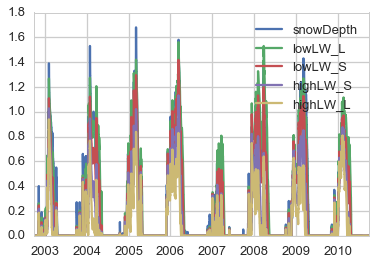

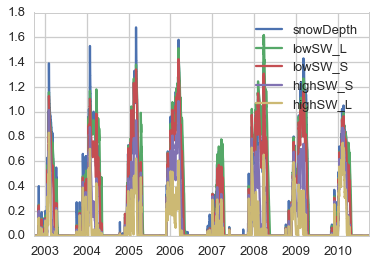

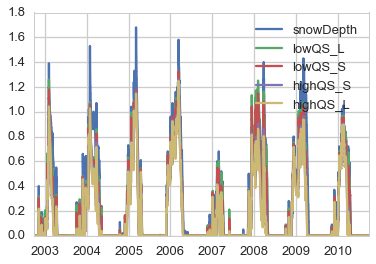

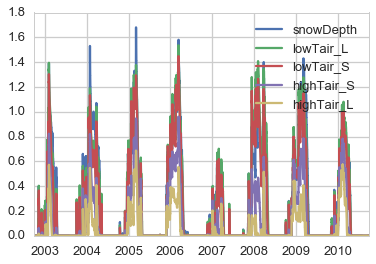

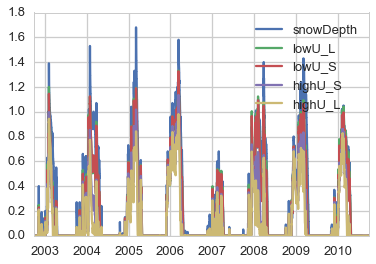

In [7]:
for expNum, exp in enumerate(experiments):
    plt.figure()
    plt.plot(CDP.time, CDP.snowDepth)

    for nameNum, names in enumerate(expNames[exp]):
        plt.plot(resultsDataSet.time, resultsDataSet.sel(expID=names).scalarSnowDepth, label=names)
    plt.legend()

### Cold content and dU/dt
- somehow messed up the Model_Output.txt. None of the necessary variables were saved
- Proceed using just surfact temperature for the time being
- Dammit

In [8]:
# ds = resultsDict['jrdn1991wy2007']
# ds = ds.squeeze('hru')
# Toffset = 273.15

# # get the time information so we can plot centered on the time step
# time = ds.time.values
# time = time - 0.5 * (time[1] - time[0]) # plot bars centered on time step

# # get the number of layers and the maximum
# layers = ds.nLayers.values.astype('int') 
# max_layers = layers.max()
# soilLayers = ds.nSoil.mean(dim='time').values.astype('int')
# snowLayers = max_layers - soilLayers

# # Set up two arrays that contain the layer information per timestep
# depths = np.empty((max_layers + 1, len(time))) * np.nan
# tmp = np.empty((max_layers, len(time))) * np.nan
# coldContent = np.empty((len(time))) * np.nan

# # extract the information from the SUMMA output and store it in the arrays
# for i in range(len(time)):
#     ifcstart = int(ds.ifcTotoStartIndex[i].values - 1)
#     midstart = int(ds.midTotoStartIndex[i].values - 1)
#     ifclayers = layers[i] + 1
#     midlayers = layers[i]
#     ifcend = int(ifcstart + ifclayers)
#     midend = int(midstart + midlayers)
#     depths[0:ifclayers, i] = -ds.iLayerHeight[ifcstart:ifcend]
#     tmp[0:midlayers, i] = ds.mLayerTemp[midstart:midend] - Toffset
# #     if ds.scalarSnowDepth > 0:
# #         coldContent = tmp[:snowLayers, i] 

# # # now plot it
# # import matplotlib as mpl
# # fig = plt.figure(figsize=(15, 10)) # set up the plot
# # colors = plt.get_cmap('RdYlBu_r') # select an appropriate color map
# # norm = mpl.colors.Normalize(vmin=-3, vmax=3) # scale the color bar
# # width = (time[1]-time[0])/np.timedelta64(1, 'D') # determine the width of the bar
# # prev = depths[0] # this is used as the "bottom" for the bars
# # # loop over each of the layers
# # for s, w in zip(depths[1:], tmp[0:]):
# #     plt.bar(time, prev-s, width=width, color=colors(norm(w)), bottom=s, edgecolor='none')
# #     prev = s
    
# # # plot a color bar
# # sm = plt.cm.ScalarMappable(cmap=colors, norm=norm)
# # sm._A = []
# # plt.colorbar(sm, extend='both', label='{} ({})'.format(ds.mLayerTemp.long_name, 'ºC'))
# # # add a top line with the snow depth
# # plt.plot(time, (ds.iLayerHeight[ds.ifcTotoStartIndex-1]*(-1)).values, color='black')

In [9]:
# print(depths[:int(ds.nLayers.values[4000]) - int(ds.nSoil.values[4000]), 4000])
# plt.plot(depths[:, 4000])
# plt.plot(tmp[:, 4000])